In [10]:
!git clone https://github.com/rangan2510/scVISA
!pip install -r /content/scVISA/requirements.txt --quiet &> /dev/null

fatal: destination path 'scVISA' already exists and is not an empty directory.


In [11]:
import scvi
from scVISA.model import scVISA

In [12]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'


In [13]:
adata = scvi.data.purified_pbmc_dataset()
print(adata)
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
adata.obs_names_make_unique()
adata

INFO     File data/PurifiedPBMCDataset.h5ad already downloaded                               


INFO:scvi.data._built_in_data._download:File data/PurifiedPBMCDataset.h5ad already downloaded


AnnData object with n_obs × n_vars = 105868 × 21932
    obs: 'cell_types', 'barcodes', 'labels', 'batch'


AnnData object with n_obs × n_vars = 105868 × 1200
    obs: 'cell_types', 'barcodes', 'labels', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [14]:
scVISA.setup_anndata(
    adata,
    layer="counts",
)
model = scVISA(adata)
model.train(10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Initialized Self-Attention Encoder
Initialized Self-Attention Encoder
Epoch 10/10: 100%|██████████| 10/10 [01:43<00:00, 10.37s/it, loss=216, v_num=1]


In [15]:
!pip install setuptools --quiet &> /dev/null

In [16]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

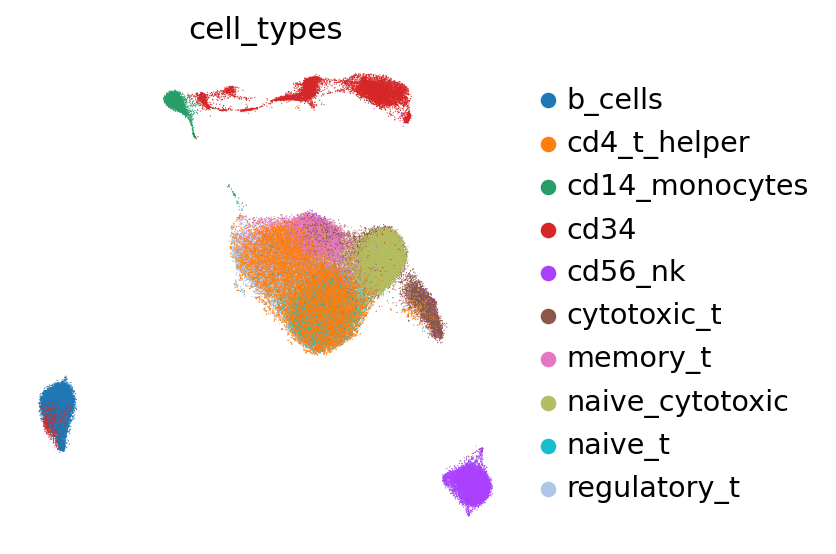

In [17]:
sc.pl.umap(
    adata,
    color=["cell_types"],
    frameon=False,
    save="_cell_type.pdf"
)

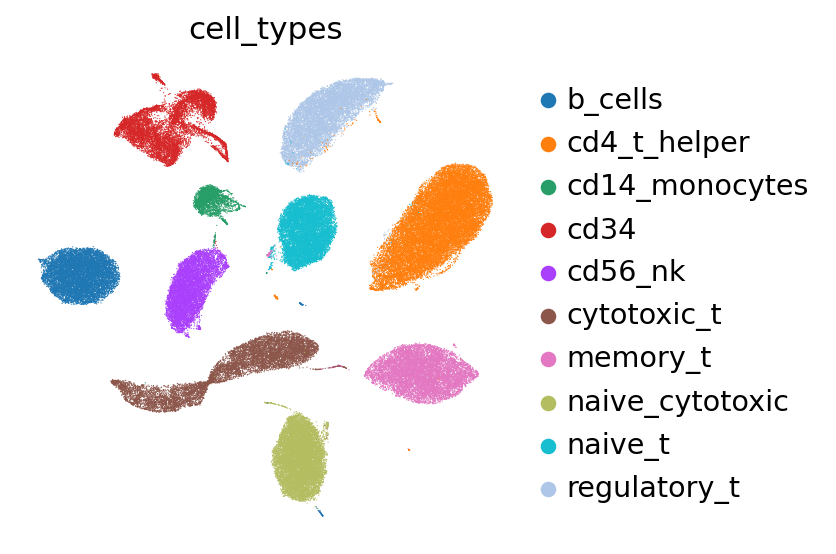

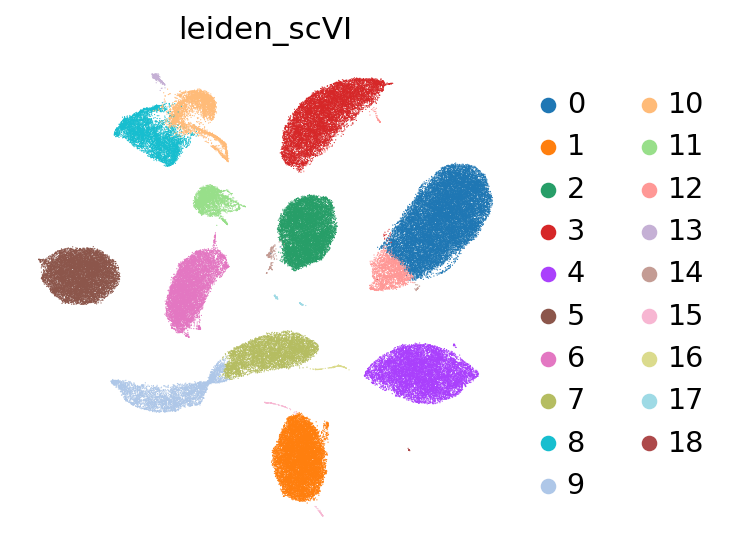

In [18]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(
    adata,
    color=["cell_types"],
    frameon=False,
    save="_cell_type2.pdf"
)


# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
    save="clustering.pdf"
)

In [19]:
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
print("ARI:\t", adjusted_rand_score(adata.obs["cell_types"], adata.obs["leiden_scVI"]))
print("NMI:\t",normalized_mutual_info_score(adata.obs["cell_types"], adata.obs["leiden_scVI"]))

ARI:	 0.9055252984255517
NMI:	 0.9404483160818142


In [20]:
adata.write("postproc.h5ad")